In [1]:
topology_file = '../out/sim/10taxa/2seed/tree-sim.newick'
beast_result_file = '../out/sim/10taxa/2seed/1000sites/beast.pickle'
correlation_plot_out_file = '../out/sim/10taxa/2seed/1000sites/rate-correlations-scaled.png'
marginal_plot_out_file = '../out/sim/10taxa/2seed/1000sites/marginals-scaled.png'
rate_marginal_plot_out_file = '../out/sim/10taxa/2seed/1000sites/rate-marginals-scaled.png'
variational_fit_file = '../out/sim/10taxa/2seed/1000sites/variational-fit-scaled.pickle'
model_file = '../config/model.yaml'
clock_approx = 'scaled'

In [21]:
from treeflow_pipeline.util import pickle_input, yaml_input

beast_result = pickle_input(beast_result_file)
variational_fit = pickle_input(variational_fit_file)

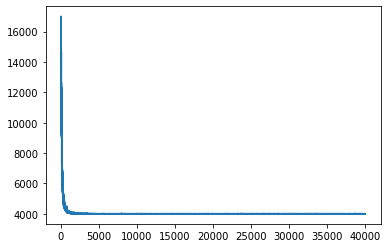

In [3]:
import matplotlib.pyplot as plt
plt.plot(variational_fit['loss'])

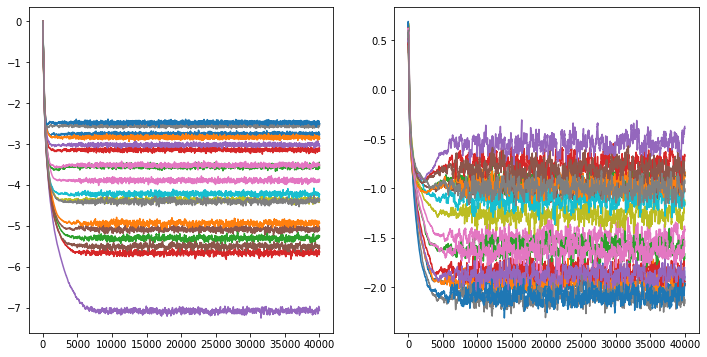

In [4]:
n_branches = beast_result['branch_lengths'].shape[1]
rate_var_traces = [x for x in variational_fit['params'] if x.shape[-1] == n_branches] # TODO: How can we make sure we get the right variables?
fig, axs = plt.subplots(ncols=len(rate_var_traces), figsize=(12, 6))
for ax, rate_var_trace in zip(axs, rate_var_traces):
    ax.plot(rate_var_trace)

## Parameter estimates

In [5]:
import treeflow_pipeline.model

model = treeflow_pipeline.model.Model(yaml_input(model_file))
approx = treeflow_pipeline.model.reconstruct_approx(topology_file, variational_fit, model, clock_approx)

### Branch rate correlations

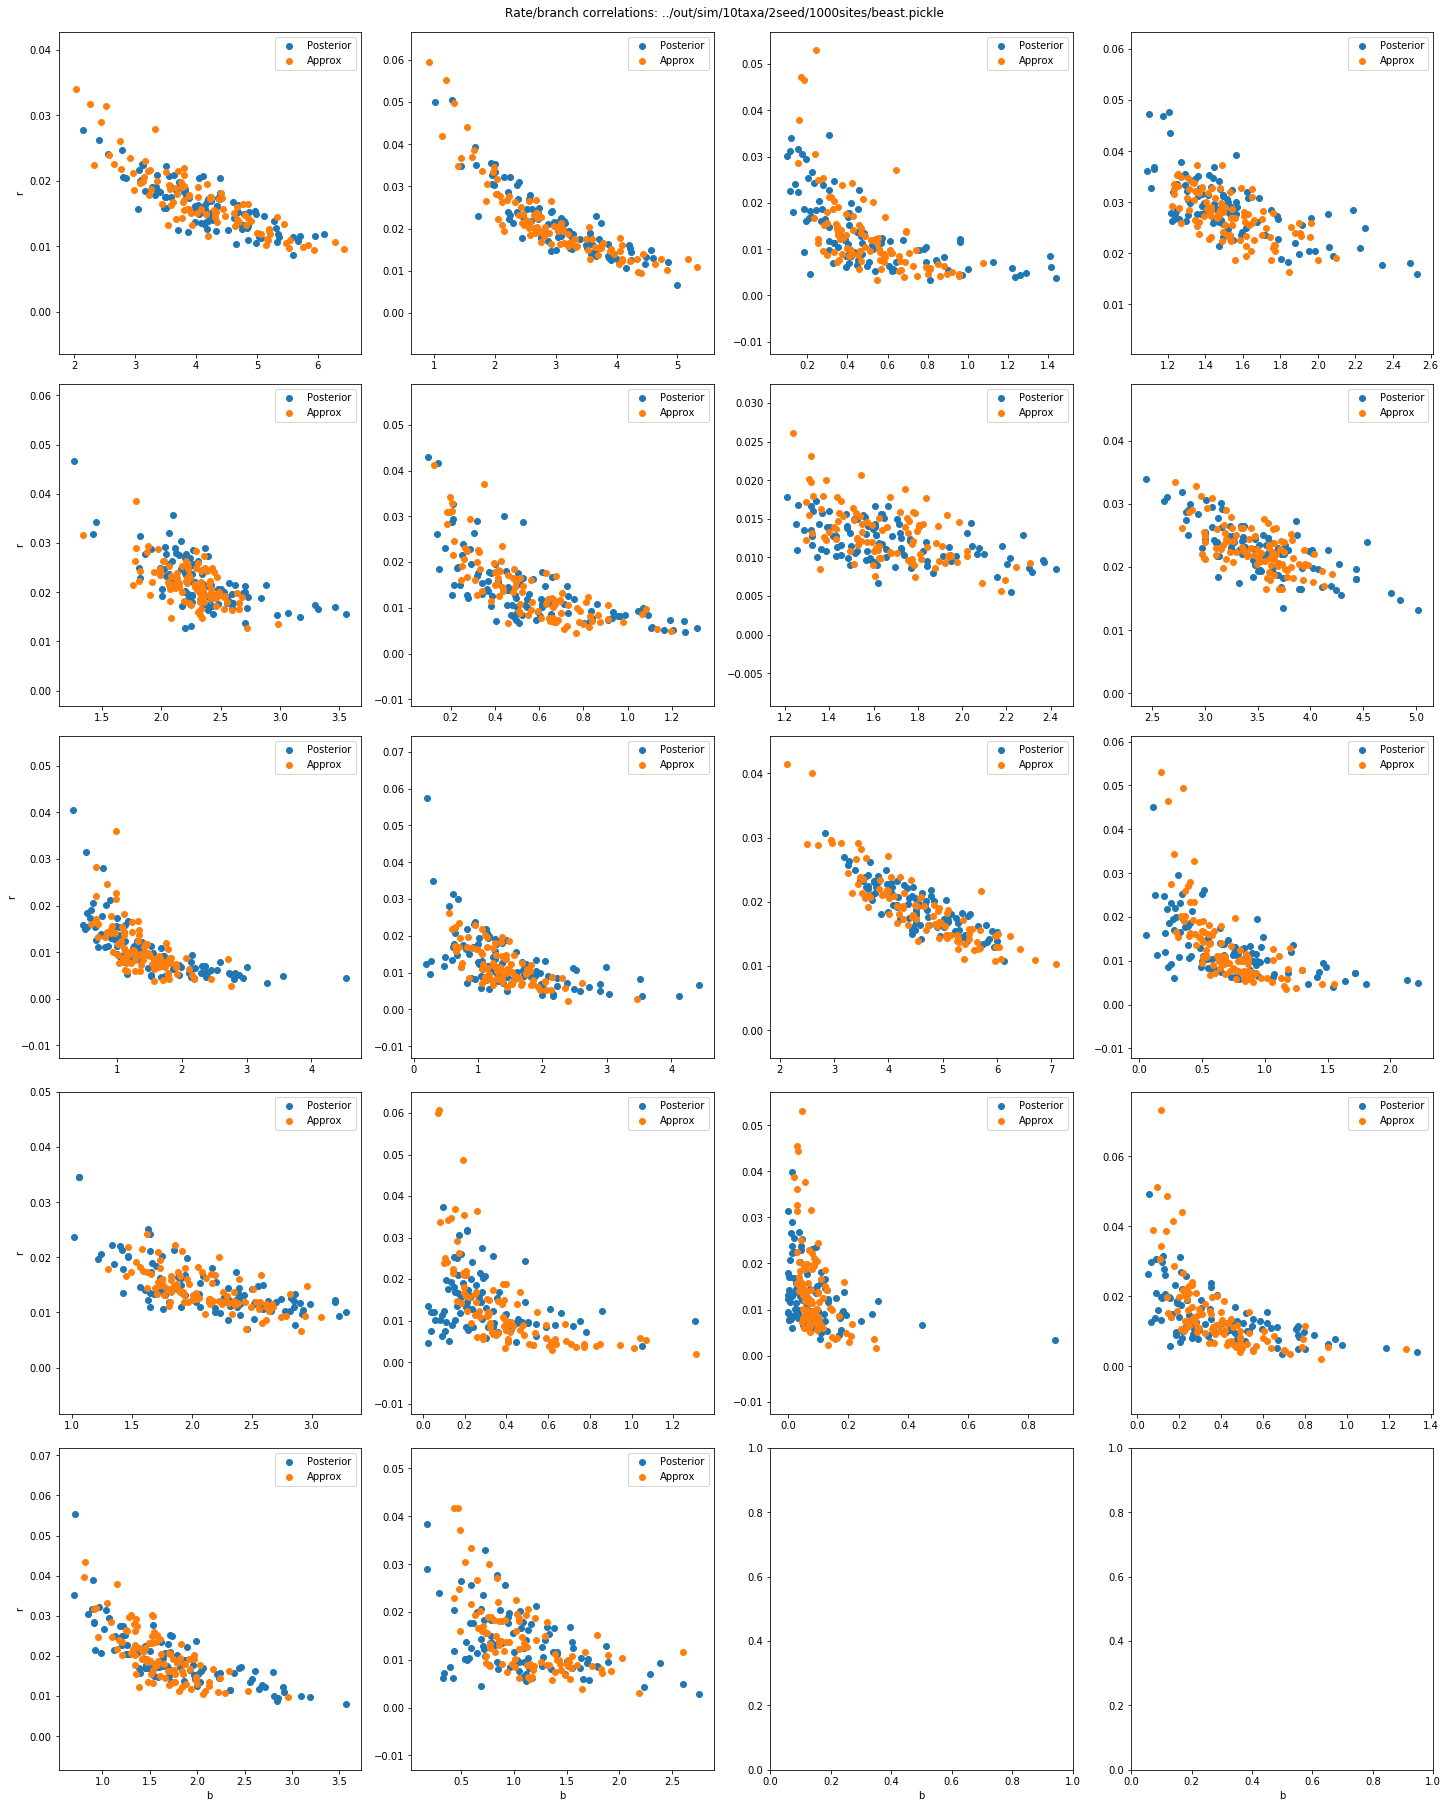

In [14]:
import treeflow.sequences
import numpy as np

n_cols = 4
n_rows = int(np.ceil(n_branches / n_cols))

n_plot_samples = 100
n_beast_samples = beast_result['branch_lengths'].shape[0]
beast_sample_indices = np.random.choice(n_beast_samples, n_plot_samples)

approx_samples = approx.sample(n_plot_samples)
approx_blens = treeflow.sequences.get_branch_lengths(approx_samples['tree'])
approx_rates_t = approx_samples['clock_rate'].numpy() * approx_samples['rates'].numpy().T
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]
for ax, branch_blens, branch_rates, approx_blens, approx_rates in zip(axs_flat, beast_result['branch_lengths'][beast_sample_indices].T, beast_result['absolute_rates'][beast_sample_indices].T, approx_blens.numpy().T, approx_rates_t):
    ax.scatter(branch_blens, branch_rates, label='Posterior')
    ax.scatter(approx_blens, approx_rates, label='Approx')
    leg = ax.legend()

for ax in axs[-1]:
    ax.set_xlabel('b')

for row in axs:
    row[0].set_ylabel('r')

plt.suptitle('Rate/branch correlations: ' + beast_result_file);
plt.savefig(correlation_plot_out_file)

### Parameter correlations

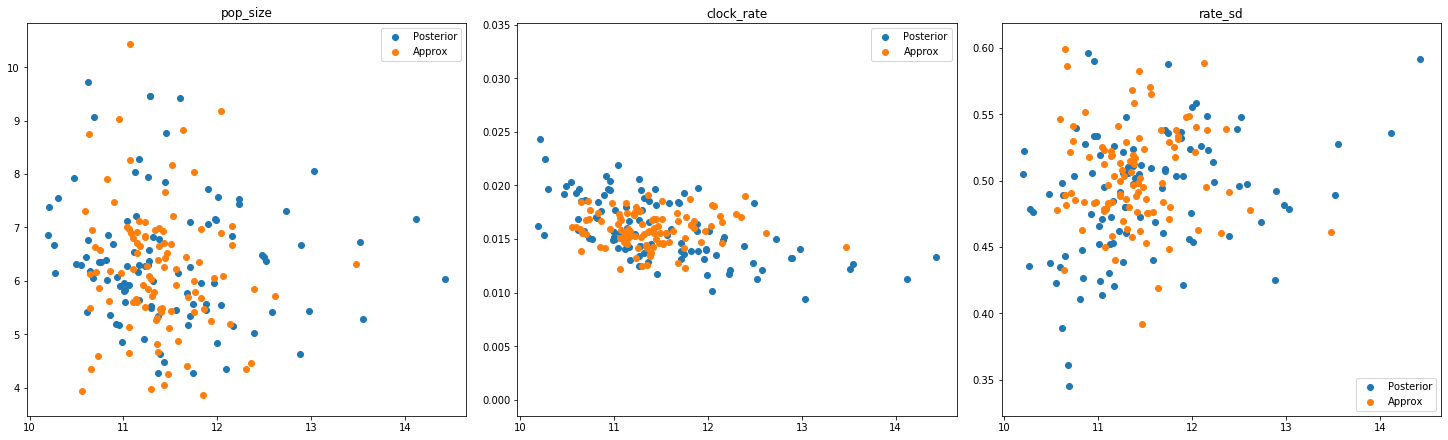

In [30]:
other_vars = model.free_params().keys()
fig, axs = plt.subplots(ncols=len(other_vars), figsize=(20, 6), constrained_layout=True)

beast_root_heights = beast_result['heights'][beast_sample_indices, -1]
approx_root_heights = approx_samples['tree']['heights'][:, -1].numpy()

for var, ax in zip(other_vars, axs):
    ax.set_title(var)
    ax.scatter(beast_root_heights, beast_result[var][beast_sample_indices], label='Posterior')
    ax.scatter(approx_root_heights, approx_samples[var], label='Approx')
    leg = ax.legend()

### Branch rate marginals

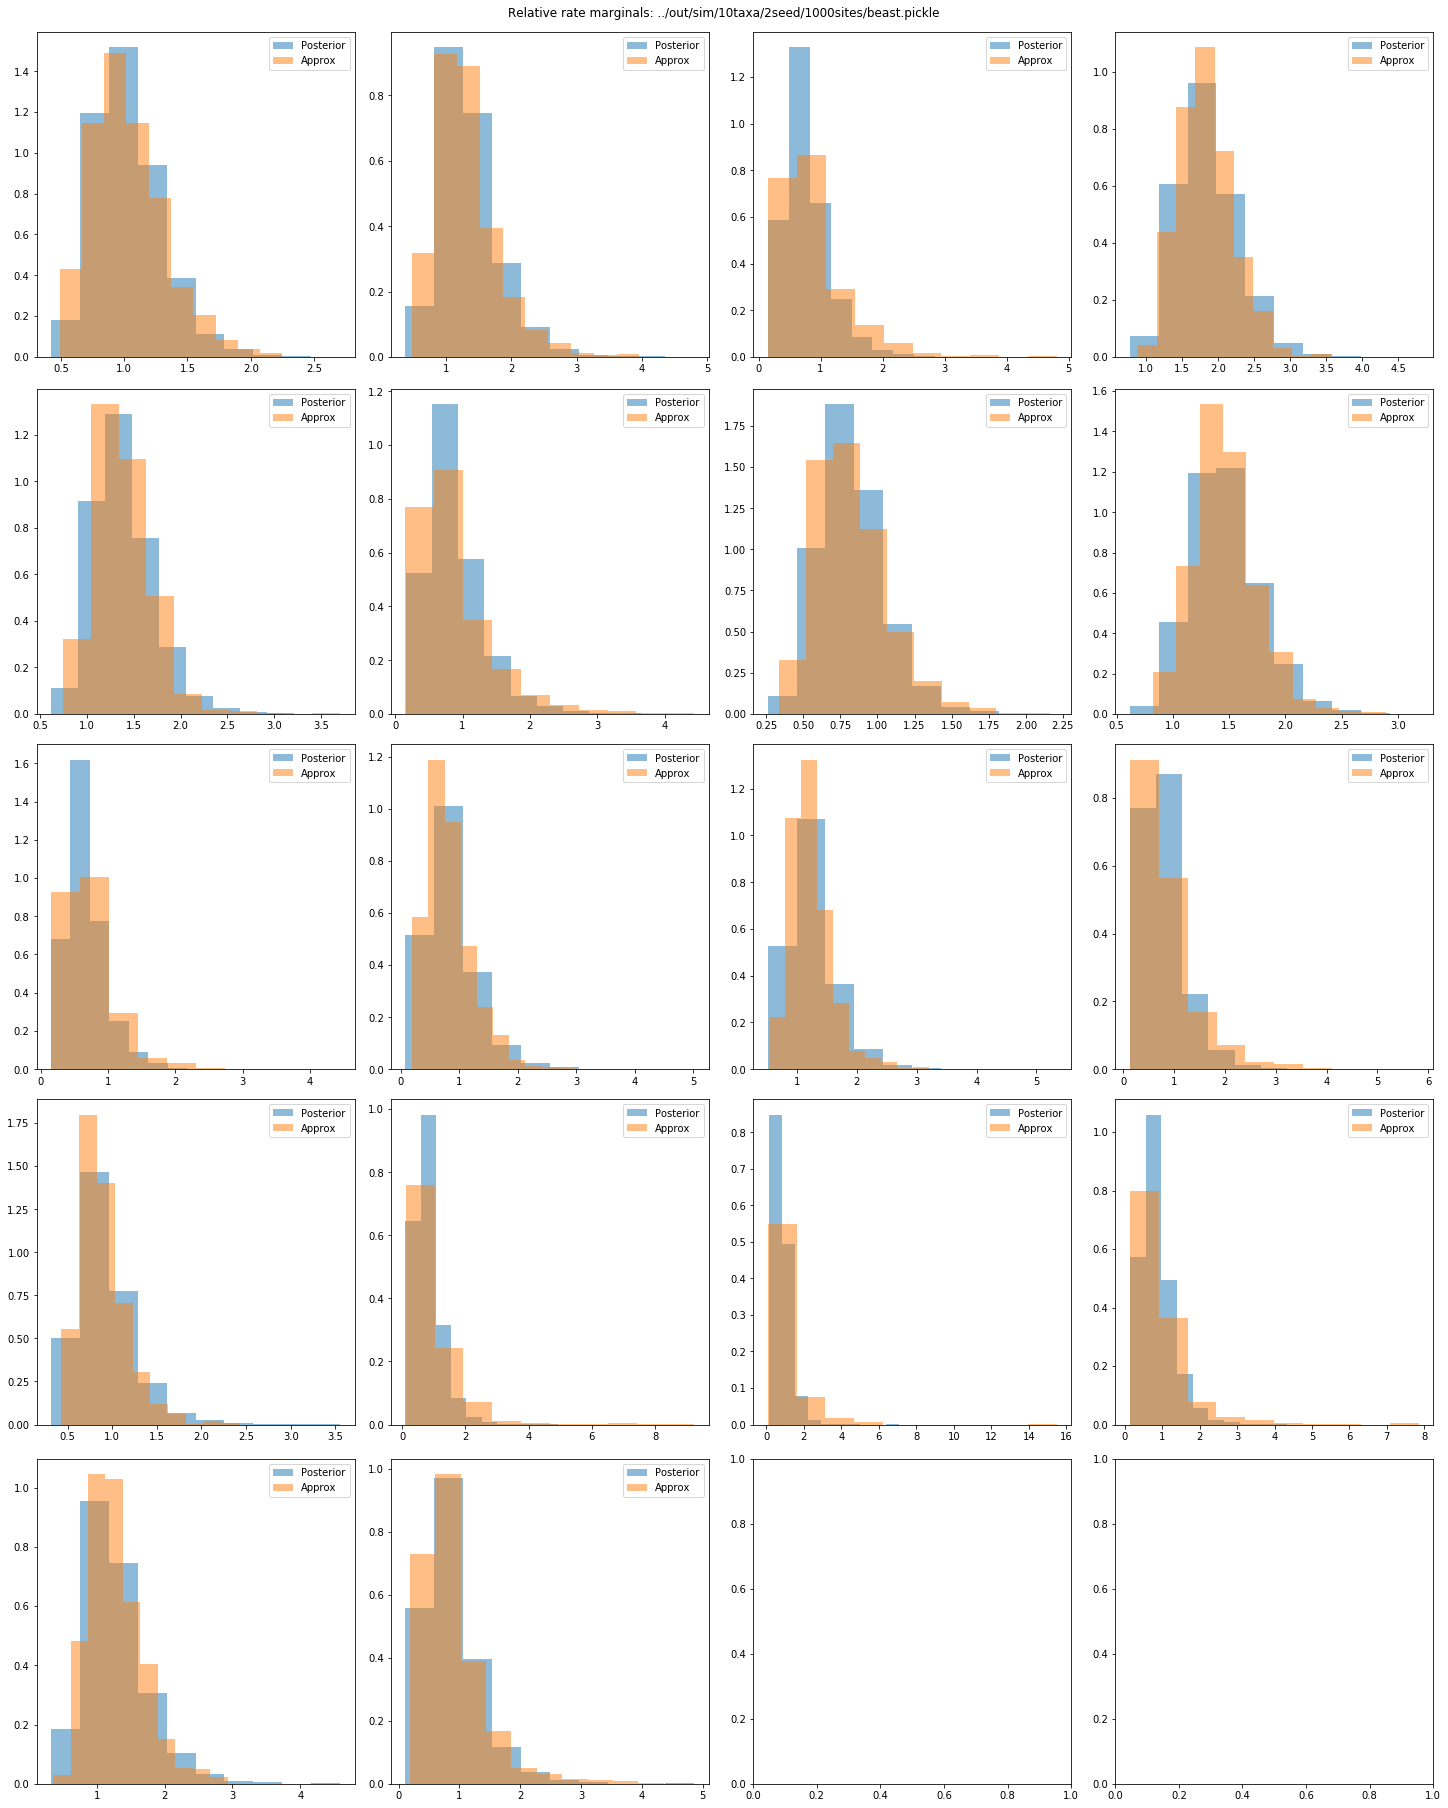

In [7]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

approx_samples = approx.sample(1000)
for ax, branch_rates, approx_rates, in zip(axs_flat, beast_result['rates'].T, approx_samples['rates'].numpy().T):
    ax.hist(branch_rates, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_rates, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()


plt.suptitle('Relative rate marginals: ' + beast_result_file);
plt.savefig(rate_marginal_plot_out_file)

### Node height marginals

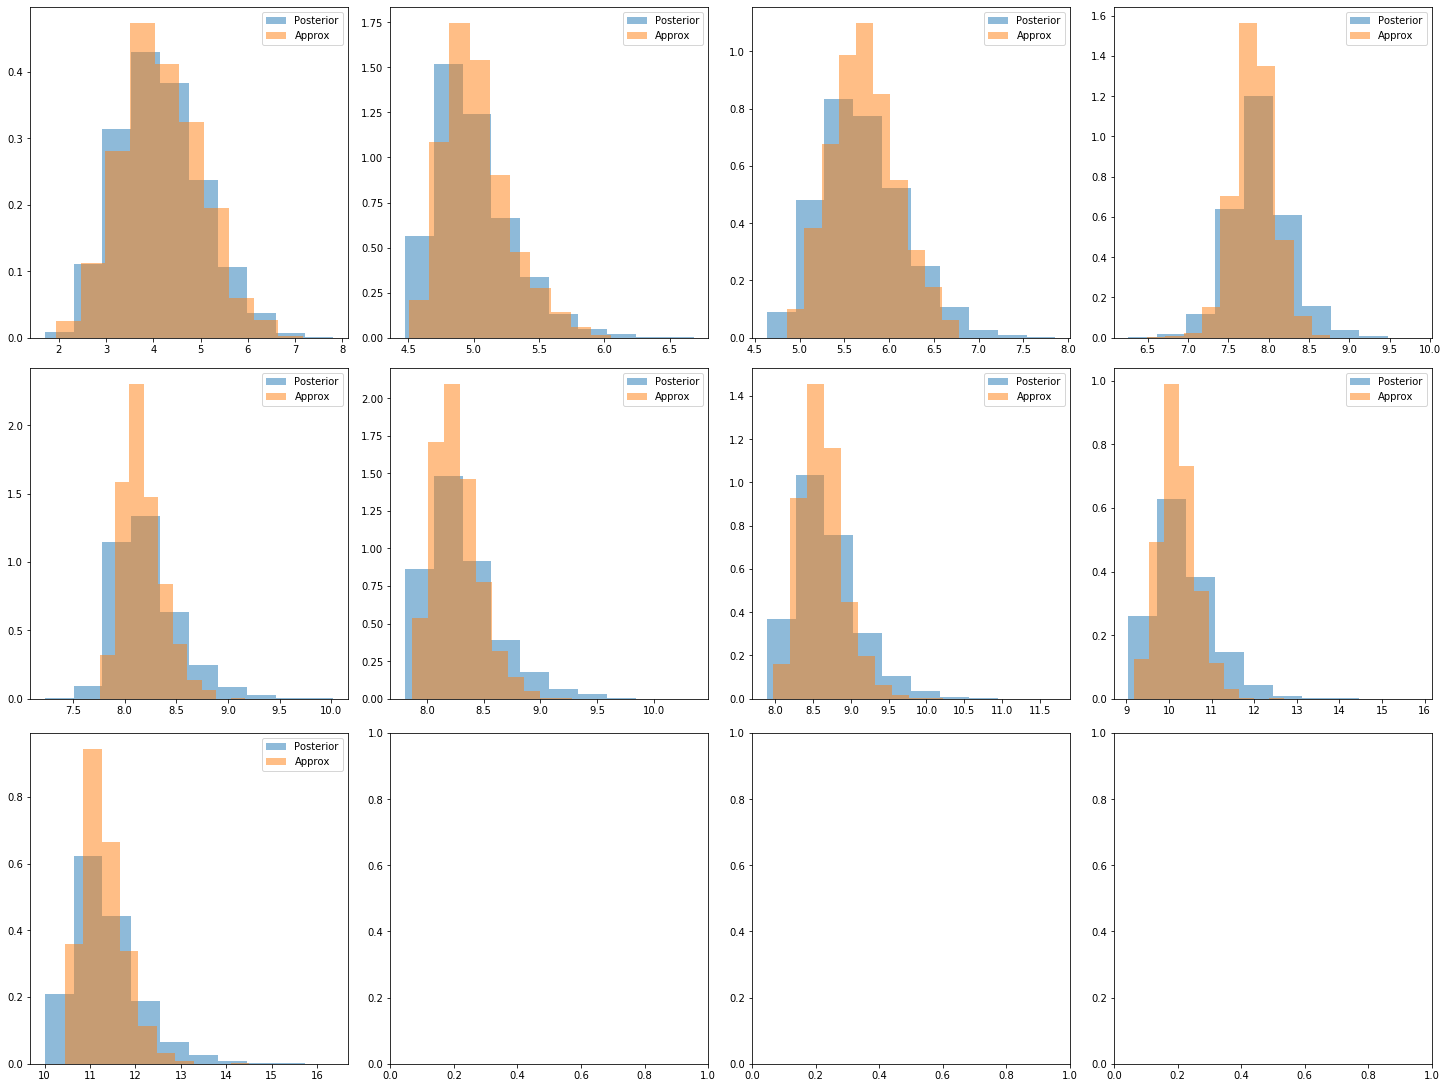

In [9]:
internal_node_count = n_branches // 2
taxon_count = internal_node_count + 1
n_rows = int(np.ceil(internal_node_count / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, heights, approx_heights, in zip(axs_flat, beast_result['heights'].T[taxon_count:], approx_samples['tree']['heights'].numpy().T[taxon_count:]):
    ax.hist(heights, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_heights, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()

### Parameter marginals

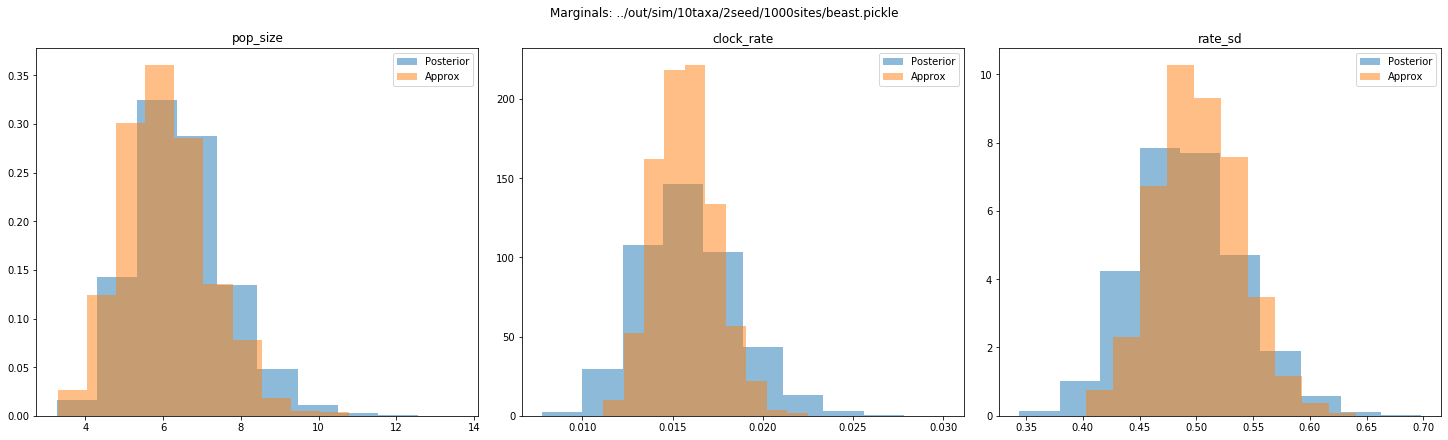

In [8]:
fig, axs = plt.subplots(ncols=len(other_vars), figsize=(20, 6), constrained_layout=True)
for var, ax in zip(other_vars, axs):
    ax.set_title(var)
    ax.hist(beast_result[var], alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_samples[var], alpha=0.5, label='Approx', density=True)
    leg = ax.legend()
    
plt.suptitle('Marginals: ' + beast_result_file);
plt.savefig(marginal_plot_out_file)